this is an example to detect surface of box or layer in case/layer pick project, by Alan Liu, Mar-29-2023 19:00 PM

In [1]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.signal import find_peaks


In [34]:
img = cv2.imread('examples/2023_3_29_14_1_4_753.tiff', cv2.IMREAD_UNCHANGED)

# Check if the image was loaded successfully
if img is not None:
#     cv2.namedWindow('TIFF Image', cv2.WINDOW_NORMAL)
#     cv2.imshow('TIFF Image', img)
    print("Image size:", img.shape)
    channels = cv2.split(img)
    # Extract the first channel
    distance = channels[0]
    x = channels[1]
    y = channels[2]
    # Display the first channel
#     cv2.namedWindow('Distance', cv2.WINDOW_NORMAL)
#     cv2.imshow('Distance', distance)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
else:
    print('Failed to open the TIFF image')
print(distance.max())
print(distance.min())
min_val = np.min(distance)
max_val = np.max(distance)
distance_normalized = (distance - min_val) * (255.0 / (max_val - min_val))

# 将归一化后的距离图像转换为8位整型
distance_normalized = distance_normalized.astype(np.uint8)

# 显示归一化后的距离图像
cv2.namedWindow('Normalized Distance', cv2.WINDOW_NORMAL)
cv2.imshow("Normalized Distance", distance_normalized)
cv2.waitKey(0)
cv2.destroyAllWindows()

Image size: (1200, 1920, 3)
0.875208
-1.0008622


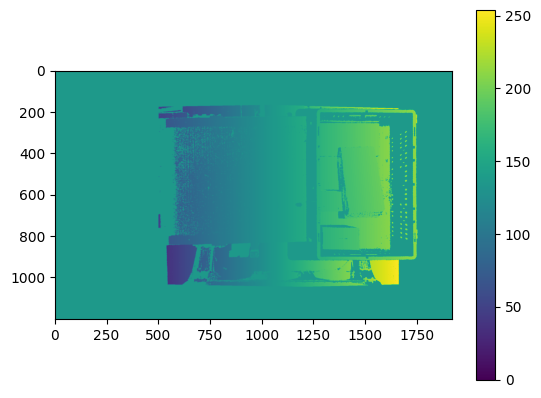

136


In [35]:
# READ THE DEPTH
# img_depth = cv2.imread('distance_image.png',  cv2.CV_16UC1)
img_depth= distance_normalized

#最近希望使用opencv处理从realsense获取的深度图像，
#但是realsense的深度图是单通道16位的，而opencv的显示函数默认接收的数据类型都是uint8，
#实际使用存在一些问题opencv的imshow只能正常显示CV_8U3C和CV_8U1C类型的图片；16位int型图片会被压缩为8位（除以256）；
#32位和64位的浮点型图片会被乘以255，从[0,1]映射到[0,255]，32位int型的数据不会做处理。所以使用imshow直接显示深度数据通常是一片漆黑。

# cv2.imshow("first",img_depth)
# cv2.waitKey()
# cv2.destroyAllWindows()
fig, ax = plt.subplots()
im = ax.imshow(img_depth, cmap='viridis')

# add the colorbar
cbar = fig.colorbar(im, ax=ax)
# plt.title(' distance image')
plt.imshow(img_depth)
plt.show()
print(img_depth[1][1])

(1200, 1920)
254
0


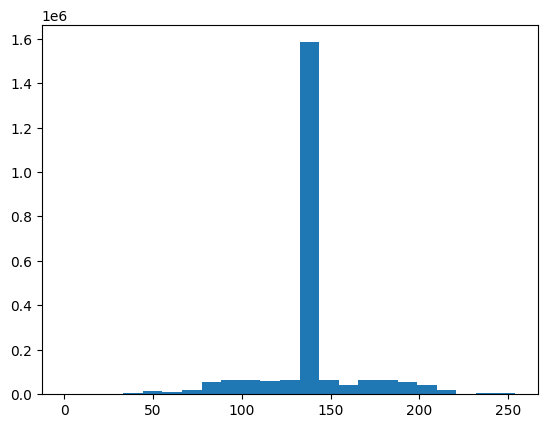

bin number =  23
vmin =  0.0
vmax =  254.0


In [37]:
max_depth = img_depth.max()
min_depth = img_depth.min()
print(img_depth.shape)
print(max_depth)
print(min_depth)
# print(img_depth)

## ravel()函数是将图像的N维数组降到一维上去，
#256为bins的数目,[0, 256]为范围
data=img_depth.ravel()
# new_data = data[data !=136]
new_data=data
# q25, q75 = np.percentile(new_data, [25, 75])
# iqr = q75 - q25
# bin_width = 2 * iqr / np.power(new_data.size, 1/3)

# compute the range of values using the 95th percentile
vmin, vmax = np.percentile(new_data, [0, 100])

# plot the histogram
hist_values, bins, patches=plt.hist(new_data, bins='auto', range=(vmin, vmax))
plt.show()
print("bin number = ", len(hist_values))
print("vmin = ",vmin)
print("vmax = ",vmax)

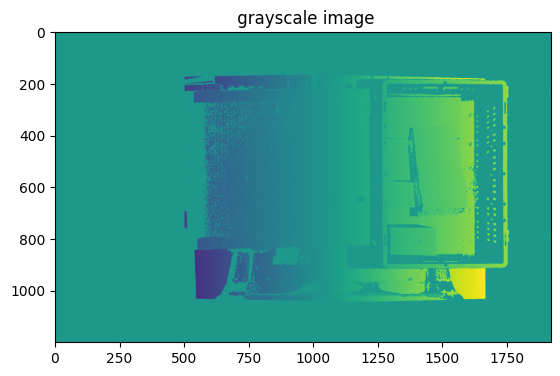

(1200, 1920)
0.875208
-1.0008622


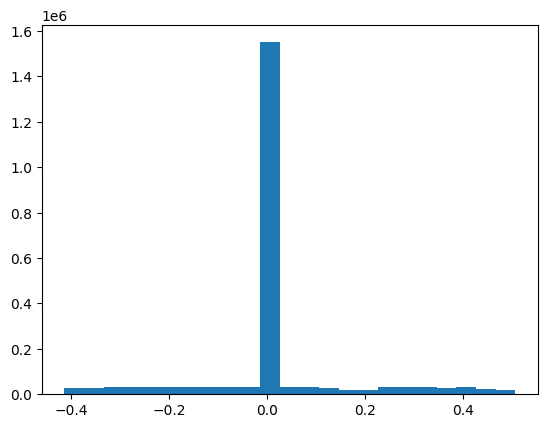

hist_values:  [  26885.   29592.   30747.   30954.   31094.   30071.   30540.   30396.
   32032.   32605. 1549460.   33149.   32613.   29786.   19897.   19807.
   31781.   33472.   32680.   28581.   32480.   22746.   17432.]
bin number =  23
vmin =  -0.41402617841958994
vmax =  0.5072727158665655
1st max value =  -0.013461442
2nd max value =  0.2669339
min value between 2 max value =  0.18682092
-0.41402617841958994
0.18682092428207397


error: OpenCV(4.7.0) C:\Users\23315\AppData\Local\Temp\pip-install-aiqzs7xn\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


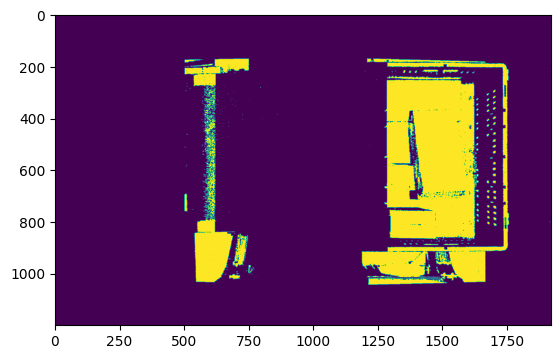

In [3]:
max_index = np.argmax(hist_values)

# 找到所有数的索引，按照从小到大的顺序排列
all_indices = np.argsort(hist_values)

# 找到倒数第二个数的索引
second_max_index = all_indices[-2]

# 打印结果
print("1st max value = ",bins[max_index])
print("2nd max value = ",bins[second_max_index])
small_index=min(max_index,second_max_index)
large_index=max(max_index,second_max_index)

min_value = min(hist_values[small_index:large_index])
min_value_index = np.where(hist_values[small_index:large_index] == min_value)[0] + small_index
edge_threshold=bins[min_value_index[0]]
print("min value between 2 max value = ",edge_threshold)

# 求得阈值，分割图像
#这一步的阈值维手工选取，需要做到自适应
# 大于150深度，变成255(黄色)
ret1, th1 = cv2.threshold(img_depth, vmin, 255, cv2.THRESH_BINARY)
print(ret1)
plt.imshow(th1)

# 求得阈值，分割图像
#这一步的阈值维手工选取，需要做到自适应
# 大于170深度，变成255(黄色)
ret2, th2 = cv2.threshold(img_depth, edge_threshold, 255, cv2.THRESH_BINARY)
print(ret2)
plt.imshow(th2)

th3 = th2 - th1
plt.imshow(th3)

#先找到所有的contour轮廓，然后针对每个轮廓点，求最小外接矩形
# 然后把最小外接矩形画在原始深度图

contours, hierarchy = cv2.findContours(th3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(contours)
#print (type(contours))  
#print (contours[0])
#print (len(contours)) 
#print(hierarchy)

cnt = max(contours, key=cv2.contourArea)
#print(cnt.shape)

rect = cv2.minAreaRect(cnt)  # rect返回矩形的特征信息，其结构为【最小外接矩形的中心（x，y），（宽度，高度），旋转角度】
print(f'(center ,width and height, and rotation angel  of laye) are:\n {rect}\n')
points = cv2.boxPoints(rect)  # 得到最小外接矩形的四个点坐标
points = np.int0(points)  # 坐标值取整
print('4 points of the rectangle layer are:')
print(points)
image = cv2.drawContours(img_depth, [points], 0, (0, 0, 255), 2)  # 直接在原图上绘制矩形框

'''
for contour in contours:
    # 绘制最小外接矩形框,
    area= cv2.contourArea(contour) #计算轮廓包络面积
    if area == max_area:
        rect = cv2.minAreaRect(contour)  # rect返回矩形的特征信息，其结构为【最小外接矩形的中心（x，y），（宽度，高度），旋转角度】
        print(f'(center ,width and height, and rotation angel  of laye) are:\n {rect}\n')
        points = cv2.boxPoints(rect)  # 得到最小外接矩形的四个点坐标
        points = np.int0(points)  # 坐标值取整
        print('4 points of the rectangle layer are:')
        print(points)
        image = cv2.drawContours(img_depth, [points], 0, (0, 0, 255), 2)  # 直接在原图上绘制矩形框

        break
'''

plt.imshow(image)

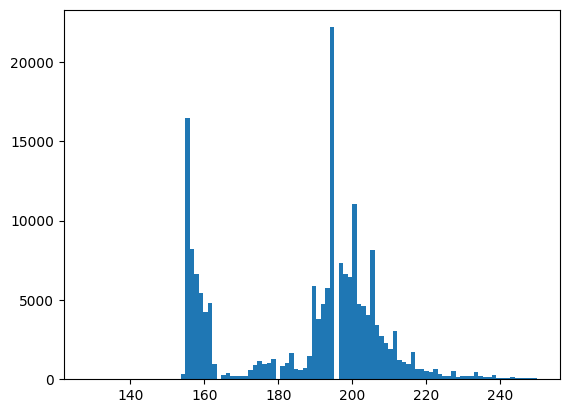

In [106]:
## ravel()函数是将图像的三位数组降到一维上去，
# creating a histogram with 100 bins, 
# the bin range is from 128 to the maximum pixel value in the image. 
# The resulting histogram will show the distribution of pixel values in the image, with the x-axis showing the pixel value range and the y-axis showing the frequency of pixels falling within each bin.
#这一步的阈值维手工选取，需要做到自适应
plt.hist(img_depth.ravel(),100, [128,max_depth-5])
plt.show()

150.0


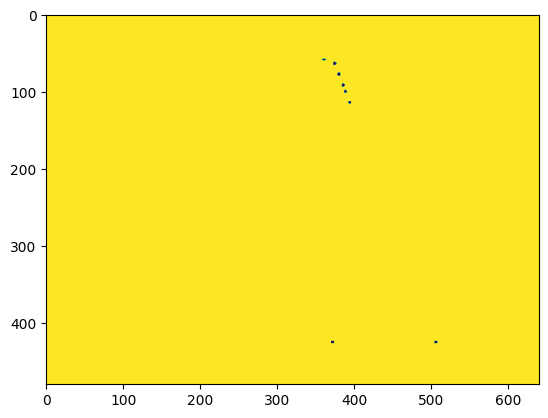

In [28]:
# 求得阈值，分割图像
#这一步的阈值维手工选取，需要做到自适应
# 大于150深度，变成255(黄色)
ret1, th1 = cv2.threshold(img_depth, 150, 255, cv2.THRESH_BINARY)
print(ret1)
plt.imshow(th1)

170.0


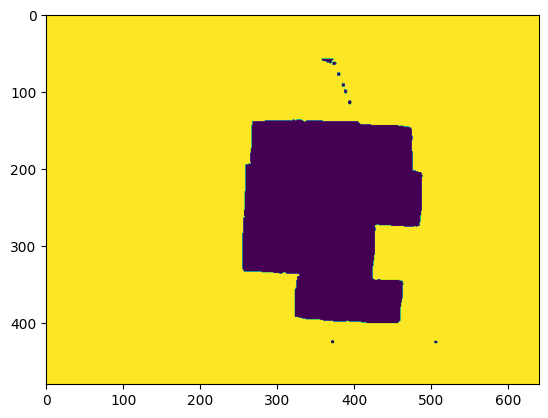

In [13]:
# 求得阈值，分割图像
#这一步的阈值维手工选取，需要做到自适应
# 大于170深度，变成255(黄色)
ret2, th2 = cv2.threshold(img_depth, 170, 255, cv2.THRESH_BINARY)
print(ret2)
plt.imshow(th2)

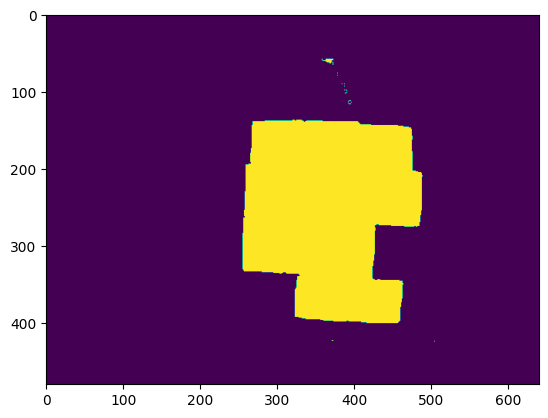

In [14]:
# 求得两个阈值之间的深度图
th3 = th2 - th1
plt.imshow(th3)

(center ,width and height, and rotation angel  of laye) are:
 ((370.6505432128906, 267.1395263671875), (228.9988555908203, 259.3252868652344), 3.012787342071533)

4 points of the rectangle layer are:
[[249 390]
 [263 131]
 [491 143]
 [478 402]]


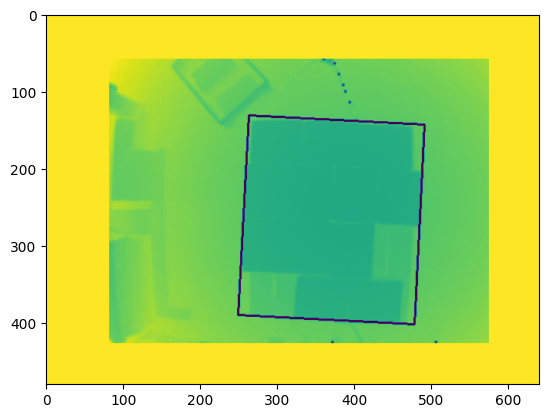

In [154]:
#先找到所有的contour轮廓，然后针对每个轮廓点，求最小外接矩形
# 然后把最小外接矩形画在原始深度图

contours, hierarchy = cv2.findContours(th3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(contours)
#print (type(contours))  
#print (contours[0])
#print (len(contours)) 
#print(hierarchy)

cnt = max(contours, key=cv2.contourArea)
#print(cnt.shape)

rect = cv2.minAreaRect(cnt)  # rect返回矩形的特征信息，其结构为【最小外接矩形的中心（x，y），（宽度，高度），旋转角度】
print(f'(center ,width and height, and rotation angel  of laye) are:\n {rect}\n')
points = cv2.boxPoints(rect)  # 得到最小外接矩形的四个点坐标
points = np.int0(points)  # 坐标值取整
print('4 points of the rectangle layer are:')
print(points)
image = cv2.drawContours(img_depth, [points], 0, (0, 0, 255), 2)  # 直接在原图上绘制矩形框

'''
for contour in contours:
    # 绘制最小外接矩形框,
    area= cv2.contourArea(contour) #计算轮廓包络面积
    if area == max_area:
        rect = cv2.minAreaRect(contour)  # rect返回矩形的特征信息，其结构为【最小外接矩形的中心（x，y），（宽度，高度），旋转角度】
        print(f'(center ,width and height, and rotation angel  of laye) are:\n {rect}\n')
        points = cv2.boxPoints(rect)  # 得到最小外接矩形的四个点坐标
        points = np.int0(points)  # 坐标值取整
        print('4 points of the rectangle layer are:')
        print(points)
        image = cv2.drawContours(img_depth, [points], 0, (0, 0, 255), 2)  # 直接在原图上绘制矩形框

        break
'''

plt.imshow(image)